In [1]:
# %pip install -U lightgbm

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, accuracy_score

import pickle
from tqdm import tqdm
import gc
from pathlib import Path

In [3]:
import warnings
import sys
from IPython.core.interactiveshell import InteractiveShell

warnings.filterwarnings("ignore")
sys.path.append("../src/")
InteractiveShell.ast_node_interactivity = "all"
tqdm.pandas()

In [4]:
from data import DataHelper, map_at_k, hr_at_k, recall_at_k

from retrieval.rules import OrderHistory, ItemPair, TimeHistory, OutOfStock
from retrieval.collector import RuleCollector

from features import cum_sale, week_sale, repurchase_ratio, purchased_before

from utils import calc_valid_date, merge_week_data


In [5]:
data_dir = Path("../data/")

In [6]:
# * 1 week will be used for validating, and the rest will be used for training
WEEK_NUM = 2

Pepare data: encoding ids and preprocessing

In [7]:
dh = DataHelper(data_dir)

In [8]:
# data = dh.preprocess_data(save=True, name="encoded_full") # * run only once

In [9]:
data = dh.load_data(name="encoded_full")

## Retrieval


Generate candidates for each week

In [9]:
for week in range(WEEK_NUM):
    trans = data["inter"]

    start_date, end_date = calc_valid_date(week)
    last_week_start = pd.to_datetime(start_date) - pd.Timedelta(days=7)
    last_week_start = last_week_start.strftime("%Y-%m-%d")
    print(f"Week {week}: [{start_date}, {end_date})")

    train, valid = dh.split_data(trans, start_date, end_date)
    last_week = train.loc[train.t_dat >= last_week_start]
    customer_list = valid["customer_id"].values

    candidates = RuleCollector().collect(
        customer_list=customer_list,
        rules=[
            OrderHistory(train, 7),
            ItemPair(OrderHistory(train, 7).retrieve()),
            TimeHistory(last_week, 12),
        ],
        filters=[OutOfStock(trans)],
        compress=False,
    )
    candidates.to_parquet(data_dir/f"interim/week{week}_candidate.pqt")
    valid.to_parquet(data_dir/f"interim/week{week}_label.pqt")

Week 0: [2020-09-16, 2020-09-23)


Retrieve items by rules: 100%|██████████| 3/3 [00:45<00:00, 15.08s/it]


Week 1: [2020-09-09, 2020-09-16)


Retrieve items by rules: 100%|██████████| 3/3 [00:47<00:00, 15.98s/it]


In [10]:
del train, valid, last_week, customer_list, candidates
gc.collect()

56

## Feature engineering


In [9]:
user = data["user"]
item = data["item"]
inter = data["inter"]

In [10]:
# merge `product_code`
inter = inter.merge(item[["article_id", "product_code"]], on="article_id", how="left")
# calculate week number
inter['week'] = (pd.to_datetime('2020-09-22') - pd.to_datetime(inter['t_dat'])).dt.days // 7

In [11]:
inter = inter.sort_values(["customer_id", "t_dat"]).reset_index(drop=True)

In [12]:
inter.shape

(31788324, 7)

Week Sale

In [13]:
inter["item_sale"] = week_sale(inter, ["article_id"])
inter["pro_sale"] = week_sale(inter, ["product_code"])
inter["item_sale_uni"] = week_sale(inter, ["article_id"], True)
inter["pro_sale_uni"] = week_sale(inter, ["product_code"], True)

inter["item_sale_ratio"] = inter["item_sale"] / (inter["pro_sale"] + 1e-6)
inter["item_sale_uni_ratio"] = inter["pro_sale_uni"] / (inter["pro_sale_uni"] + 1e-6)

item_feats = [
    "product_type_no",
    "product_group_name",
    "graphical_appearance_no",
    "colour_group_code",
    "perceived_colour_value_id",
    "perceived_colour_master_id",
]
inter = inter.merge(item[["article_id", *item_feats]], on="article_id", how="left")

for feat in tqdm(item_feats):
    inter[f"{feat}_sale"] = week_sale(inter, [feat], f"{feat}_sale")

inter = inter.drop(columns=item_feats)

100%|██████████| 6/6 [01:03<00:00, 10.58s/it]


Repurchase Ratio

In [14]:
inter['i_repurchase_ratio'] = repurchase_ratio(inter, ['article_id'])
inter['p_repurchase_ratio'] = repurchase_ratio(inter, ['product_code'])

Already Bought Item

In [15]:
inter["purchased_item"] = purchased_before(inter, ["article_id"])
inter["purchased_pro"] = purchased_before(inter, ["product_code"])

Save data

In [16]:
inter.shape

(31788324, 23)

In [17]:
inter.to_parquet(data_dir / "interim/processed_inter.pqt")

## Merge Features


In [10]:
candidates = []
labels = []
for i in range(WEEK_NUM):
    tmp_candidate = pd.read_parquet(data_dir / f"interim/week{i}_candidate.pqt")
    tmp_label = pd.read_parquet(data_dir / f"interim/week{i}_label.pqt")
    candidates.append(tmp_candidate)
    labels.append(tmp_label)

In [11]:
inter = pd.read_parquet(data_dir / "interim/processed_inter.pqt")
data["inter"] = inter

Merge features

In [13]:
for i in range(WEEK_NUM):
    candidates[i] = merge_week_data(data, i, candidates[i], labels[i])

100%|██████████| 1179905/1179905 [00:41<00:00, 28452.07it/s]


Merge user and item embeddings

In [14]:
dssm_user_embd = np.load(data_dir / "external/dssm_user_embd.npy", allow_pickle=True)
dssm_item_embd = np.load(data_dir / "external/dssm_item_embd.npy", allow_pickle=True)

for i in range(WEEK_NUM):
    tmp = candidates[i]
    tmp["dssm_similarity"] = tmp[["customer_id", "article_id"]].progress_apply(
        lambda x: dssm_user_embd[x["customer_id"] - 1]
        @ dssm_item_embd[x["article_id"] - 1].T,
        axis=1,
    )
    candidates[i] = tmp

del dssm_user_embd, dssm_item_embd
gc.collect()

100%|██████████| 1179905/1179905 [00:48<00:00, 24229.89it/s]


9

In [15]:
yt_user_embd = np.load(data_dir / "external/yt_user_embd.npy", allow_pickle=True)
yt_item_embd = np.load(data_dir / "external/yt_item_embd.npy", allow_pickle=True)

for i in range(WEEK_NUM):
    tmp = candidates[i]
    tmp["yt_similarity"] = tmp[["customer_id", "article_id"]].progress_apply(
        lambda x: yt_user_embd[x["customer_id"] - 1]
        @ yt_item_embd[x["article_id"] - 1].T,
        axis=1,
    )
    candidates[i] = tmp

del yt_user_embd, yt_item_embd
gc.collect()

100%|██████████| 1179905/1179905 [00:48<00:00, 24170.17it/s]


9

Save results

In [16]:
for i, df in enumerate(candidates):
    df.to_parquet(data_dir / f"interim/week{i}_candidate_full.pqt")

## Ranking


In [18]:
candidates = []
labels = []
for i in range(WEEK_NUM):
    tmp_candidate = pd.read_parquet(data_dir / f"interim/week{i}_candidate_full.pqt")
    tmp_label = pd.read_parquet(data_dir / f"interim/week{i}_label.pqt")
    candidates.append(tmp_candidate)
    labels.append(tmp_label)

In [19]:
feats = [x for x in candidates[0].columns if x not in ['label','sales_channel_id','t_dat','week']]
cat_features = [
    "method", # * retrieval method
    "customer_id",
    "article_id",
    "product_code",
    "FN",
    "Active",
    "club_member_status",
    "fashion_news_frequency",
    "age",
    "product_type_no",
    "product_group_name",
    "graphical_appearance_no",
    "colour_group_code",
    "perceived_colour_value_id",
    "perceived_colour_master_id",
]

In [21]:
full = pd.concat(candidates, axis=0).reset_index(drop=True)
full[cat_features] = full[cat_features].astype("category")
sizes = [df.shape[0] for df in candidates]

for i in range(WEEK_NUM):
    candidates[i] = full[full['week']==i].reset_index(drop=True)

del full
gc.collect()

0

### Training


In [22]:
params = {
    "objective": "lambdarank",
    "boosting_type": "dart",
    "metric": "map",
    "max_depth": 8,
    "num_leaves": 128,
    "learning_rate": 0.05,

    "verbose": -1,
    "eval_at": 12,
    # 'device':'gpu'
}


#### Loacal Validation

In [23]:
train = pd.concat(candidates[1:WEEK_NUM])
train = train.sort_values(by=['week', 'customer_id'],ascending=True).reset_index(drop=True)

In [24]:
valid = candidates[0]
valid = valid.sort_values(by=['customer_id'],ascending=True).reset_index(drop=True)

In [25]:
train_group = train[["customer_id", "article_id", "week"]]
train_group = train_group.astype("int")
train_group = train_group.groupby(["week","customer_id"])['article_id'].count().values

valid_group = valid[["customer_id", "article_id"]]
valid_group = valid_group.astype("int")
valid_group = valid_group.groupby(["customer_id"])['article_id'].count().values

In [29]:
train_set = lgb.Dataset(
    data=train[feats],
    label=train["label"],
    group=train_group,
    feature_name=feats,
    categorical_feature=cat_features,
    params=params,
)

valid_set = lgb.Dataset(
    data=valid[feats],
    label=valid["label"],
    group=valid_group,
    feature_name=feats,
    categorical_feature=cat_features,
    params=params,
)

ranker = lgb.train(
    params,
    train_set,
    num_boost_round=250,
    valid_sets=[valid_set],
    callbacks=[lgb.early_stopping(10, first_metric_only=True), lgb.log_evaluation(10)],
    # feval=lambda preds, train_data: [auc(preds, train_data), accuracy(preds, train_data)],
)
ranker.save_model(data_dir / "interim/lgb_ranker.model", num_iteration=ranker.best_iteration)

[10]	valid_0's map@12: 0.915012
[20]	valid_0's map@12: 0.915562
[30]	valid_0's map@12: 0.916033
[40]	valid_0's map@12: 0.916546
[50]	valid_0's map@12: 0.916132
[60]	valid_0's map@12: 0.916753
[70]	valid_0's map@12: 0.916153
[80]	valid_0's map@12: 0.916157
[90]	valid_0's map@12: 0.915783
[100]	valid_0's map@12: 0.915905
[110]	valid_0's map@12: 0.91546
[120]	valid_0's map@12: 0.915718
[130]	valid_0's map@12: 0.916001
[140]	valid_0's map@12: 0.915707
[150]	valid_0's map@12: 0.915786
[160]	valid_0's map@12: 0.916003
[170]	valid_0's map@12: 0.915529
[180]	valid_0's map@12: 0.915259
[190]	valid_0's map@12: 0.9155
[200]	valid_0's map@12: 0.914929
[210]	valid_0's map@12: 0.915117
[220]	valid_0's map@12: 0.915245
[230]	valid_0's map@12: 0.914893
[240]	valid_0's map@12: 0.914751
[250]	valid_0's map@12: 0.91499


#### Inference

In [30]:
ranker = lgb.Booster(model_file=data_dir / "interim/lgb_ranker.model")

<Figure size 576x864 with 0 Axes>

<AxesSubplot:xlabel='importance', ylabel='feature'>

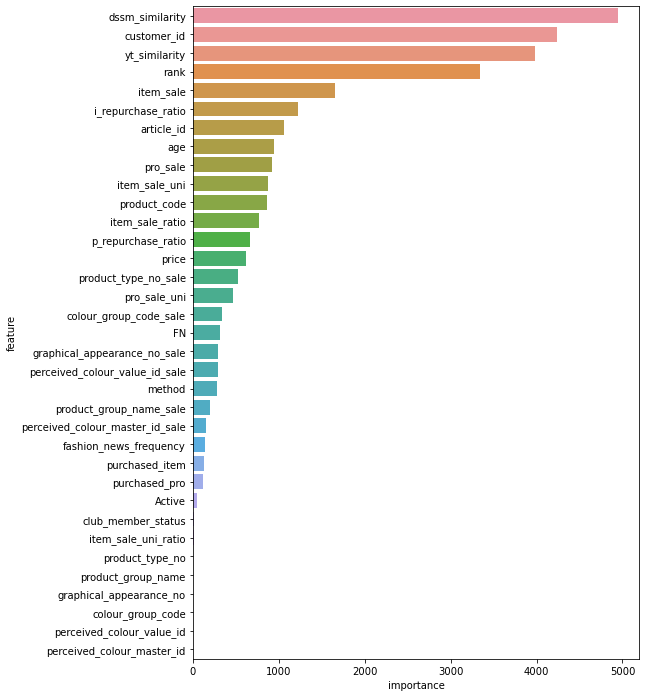

In [31]:
feat_importance = pd.DataFrame(
    {"feature": feats, "importance": ranker.feature_importance()}
).sort_values(by="importance", ascending=False)
plt.figure(figsize=(8, 12))
sns.barplot(y="feature", x="importance", data=feat_importance)

### Predict

In [32]:
candidates0 = candidates[0].reset_index(drop=True)

In [33]:
probs = np.zeros(candidates0.shape[0])
batch_size = 5_000_000
for batch in tqdm(range(0, candidates0.shape[0], batch_size)):
    outputs = ranker.predict(candidates0.loc[batch : batch + batch_size - 1, feats])
    probs[batch : batch + batch_size] = outputs

100%|██████████| 1/1 [00:10<00:00, 10.15s/it]


In [34]:
candidates0["prob"] = probs

In [35]:
pred_lgb = candidates0[['customer_id','article_id','prob']]
pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)

In [36]:
pred_lgb = pred_lgb.groupby("customer_id")["prediction"].apply(list).reset_index()

In [38]:
label = pd.read_parquet(data_dir / "interim/week0_label.pqt")
label = pd.merge(label, pred_lgb, on="customer_id", how="left")

In [39]:
map_at_k(label["article_id"], label["prediction"], k=12)

0.025023180133485097